In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid') 

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    # your code here
    return np.array((X - np.mean(X)) / np.std(X))

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        # your code here
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None):
        self.mean = np.mean(X) if self.with_mean else 0
        self.std = np.std(X) if self.with_std else 1
        return self

    def transform(self, X, y=None, copy=None):
        # your code here
        if self.copy:
            X = X.copy(deep=True)
        
        return(np.array((X - self.mean) / self.std))


In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ 7.43047681,  1.39208176],
       [ 0.94611615, -0.99124295],
       [ 3.23904583,  1.34557699],
       ...,
       [17.07670334,  5.64080647],
       [19.17302889,  5.25079786],
       [-6.78692117,  5.3180557 ]])

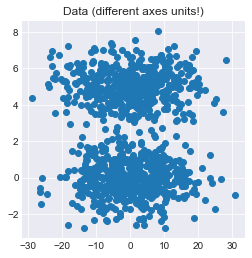

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

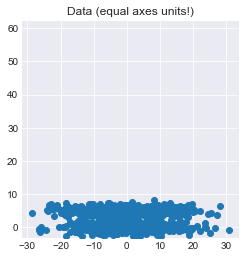

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

In [12]:
def scalling_ploter(scaler):
    scaled_data = scaler.fit_transform(data)
    plot_scatter( \
                scaled_data[:, 0],
                scaled_data[:, 1],
                auto_scaled=False ,
                title='Масштабирование с помощью ' + scaler.__class__.__qualname__
                );
    return(scaled_data)

### MinMaxScaling (0.5 point)

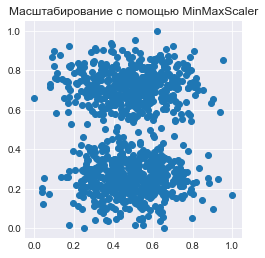

In [13]:
## your code
min_max_scaled_data = scalling_ploter(MinMaxScaler())

### StandardScaler (0.5 point)

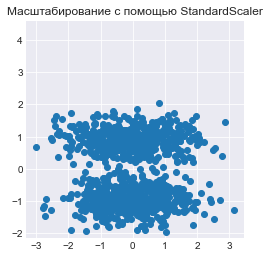

In [14]:
## your code
standard_scaled_data = scalling_ploter(StandardScaler())

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


In [15]:
from sklearn.cluster import KMeans

def kmeans_ploter(dataset, title):
    clusters = KMeans(n_clusters=2, random_state=42).fit_predict(dataset)
    plot_scatter( \
                dataset[:, 0],
                dataset[:, 1],
                auto_scaled=False ,
                title=title,
                clusters=clusters
                );

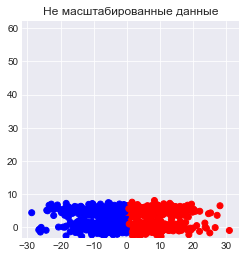

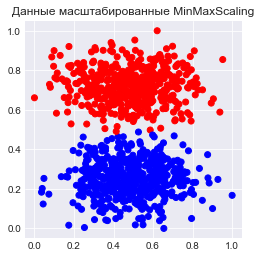

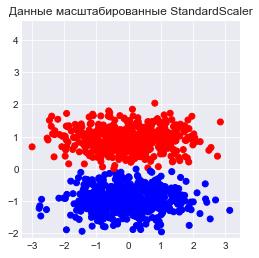

In [16]:
## your code
kmeans_ploter(data, "Не масштабированные данные")
kmeans_ploter(min_max_scaled_data, "Данные масштабированные MinMaxScaling")
kmeans_ploter(standard_scaled_data, "Данные масштабированные StandardScaler")

*****
### `КОММЕНТАРИЙ`
>Можно селать следующие выводы:
>* В масштабированных данных проще "рассмотреть" классы.
>* В нашем случае масштабирование с помощью MinMaxScaling качественне отделила классы друг от друга чем StandardScaler.
>* Скорее всего, для определения какой метод масштабирования использовать, требуется проводить исследование.
*****


## Exercise  3 - Preprocessing Pipeline (2 points)

In [17]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

*****
### `КОММЕНТАРИЙ`
>Рассмотрим несколько случаев:
>1. "пустая" модель, без каких либо воздействий на ней
>1. она же, но с масштабированием StandardScaler
>1. она же, но с масштабированием StandardScaler и выбором паметров через SequentialFeatureSelector
*****


In [18]:
## your code
def print_score(pipe, print_comment):
    print(
            accuracy_score(
                            wine_labels_val,
                            pipe.fit(wine_train, wine_labels_train).predict(wine_val)
                            ),
            print_comment
         )

In [19]:
model_clear = LogisticRegression(solver='liblinear', random_state=42)
model_l1 = LogisticRegression(solver='liblinear', penalty='l1', random_state=42)
comments = [
    "               - Исходная базовая модель (без штрафа)",
    "- Исходная базовая модель (без штрафа) и StandardScaler",
    "- Исходная базовая модель (l1)",
    "- Исходная базовая модель (l1) и StandardScaler",
    "- Исходная базовая модель (l1), StandardScaler и выбор параметров с помощью SequentialFeatureSelector"
]

pipes = [
    model_clear,
    make_pipeline(StandardScaler(), model_clear),
    model_l1,
    make_pipeline(StandardScaler(), model_l1),
    make_pipeline(StandardScaler(), SequentialFeatureSelector(model_l1, scoring='accuracy'), model_l1)
]

for pipe, comment in zip(pipes, comments):
    print_score(pipe, comment)


1.0                - Исходная базовая модель (без штрафа)
0.9814814814814815 - Исходная базовая модель (без штрафа) и StandardScaler
0.9814814814814815 - Исходная базовая модель (l1)
0.9814814814814815 - Исходная базовая модель (l1) и StandardScaler
0.9629629629629629 - Исходная базовая модель (l1), StandardScaler и выбор параметров с помощью SequentialFeatureSelector


*****
### `ИТОГИ`
Складывается ощущение, что масштабирование не оказывает влияния на логистическую регрессию.
Более того, без применения регуляризации происходит улудшение оценки (но это, возможно, связано с переобучением).

Отбор параметров (SequentialFeatureSelector) так же ухудшает результат.

Тестирование моделей всё больше напоминает шаманство, потому что противоречит объяснениям ранее сформулированным в предыдущих модулях.
*****

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [20]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [21]:
## your code
scaled_data = StandardScaler().fit_transform(wine_data)
S = np.cov(scaled_data.T)
# Можно вот так:
# S = (scaled_data.T @ scaled_data) / (scaled_data.shape[0] - 1)

If your code is correct, the following assert should be Ok.

In [22]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [23]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return -(x.T @ S @ x)

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return (1 - x.T @ x)

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(wine_data.shape[1]) # your code: initial vector to start optimization

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [24]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    return -(x.T @ x0)

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros(wine_data.shape[1]) # your code: initial vector to start optimization


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2] #your code
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [25]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

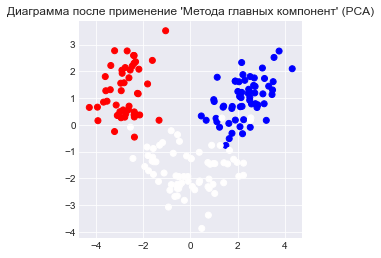

In [26]:
plot_scatter(
    (scaled_data @ x0),
    (scaled_data @ x1),
    clusters=wine_labels,
    auto_scaled=True,
    title="Диаграмма после применение 'Метода главных компонент' (PCA)"
)

*****
### `КОММЕНТАРИЙ`
>Для понимания того, произошло ли что-то отобразим исходные, масштабированные данные:
*****


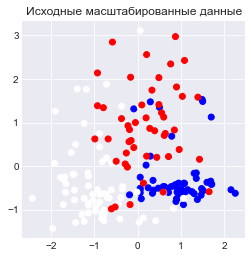

In [27]:
plot_scatter(
    scaled_data[:, 0],
    scaled_data[:, 1],
    clusters=wine_labels,
    auto_scaled=True,
    title="Исходные масштабированные данные"
)

*****
### `КОММЕНТАРИЙ`
>'Метод главных компонент' (PCA) позволил более качественно обозначить классы (класстеры).
*****


## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [28]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

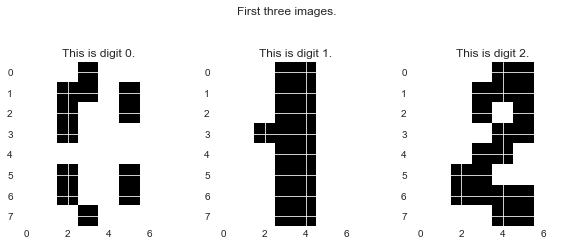

In [29]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) ## your code here

In [31]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [32]:
clf = RandomForestClassifier(max_depth=13, random_state=42)
# your code here
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_val)

acc = accuracy_score(y_val, y_predicted) # your code here
acc_save = acc
print(acc)

0.9938271604938271


In [33]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [34]:
# ! pip install boruta

In [35]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

# your code here: do run the boruta
feat_selector.fit(X_train.to_numpy(), y_train.to_numpy())

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x1812CC93240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1812CC93240)

In [36]:
accepted = X.columns[feat_selector.support_].to_list()
irresolution = X.columns[feat_selector.support_weak_].to_list()


print(accepted, "\n")
print(irresolution, "\n")
print(np.array(feat_selector.support_ * 1).reshape(8,8))

['pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_1_2', 'pixel_1_5', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_7_2', 'pixel_7_3', 'pixel_7_5', 'pixel_7_6'] 

['pixel_1_4'] 

[[0 0 1 1 1 1 0 0]
 [0 0 1 0 0 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 0]
 [0 0 1 1 0 1 1 0]]


Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

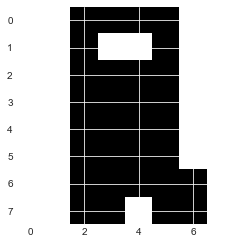

In [37]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [38]:
clf = RandomForestClassifier(max_depth=13, random_state=42)

# your code here
X_train_boruta = feat_selector.transform(X_train.to_numpy())
X_val_boruta = feat_selector.transform(np.array(X_val))

clf.fit(X_train_boruta, y_train)
y_predicted = clf.predict(X_val_boruta)

acc = accuracy_score(y_val, y_predicted) # your code here
print(acc)

0.9938271604938271


In [39]:
# Размер исходного датасета
X_train.shape

(375, 64)

In [40]:
# Размер датасетат после исключения обработки с использованием BorutaPy
X_train_boruta.shape

(375, 31)

In [41]:
assert acc > 0.99

In [42]:
# Отличие метрик при использовании исходного датасетаи и обработанного с помощью BorutaPy
acc_save - acc

0.0

*****
### `КОММЕНТАРИЙ`
>Таким образом, видим, что уменьшение количества столбцов в обучающем датастете с 64 до 31 не повлияло на качество предсказания модели.
>
>Cмысл в том, что мы понизили размерность без потери качества.

*****


# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market